## Load packages

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## Read data

In [2]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_AD_dict.pkl', 'rb'))
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks', concatenated_df)

In [3]:
## SNPs
parquet_file_path="/lustre1/project/stg_00079/students/tingting/data/GWAS/010results_bed/Bellenguez_etal_Stage1_results_pval0.1.parquet"
snps=duckdb.read_parquet(parquet_file_path)

In [4]:
query=f"""
SELECT * from snps LIMIT 10
"""
duckdb.query(query)

┌────────────┬───────────┬───────────┬─────────────┬─────────┐
│ Chromosome │ start_pos │  snp_pos  │    rsid     │  p_val  │
│  varchar   │   int64   │   int64   │   varchar   │ double  │
├────────────┼───────────┼───────────┼─────────────┼─────────┤
│ chr10      │  80874308 │  80874309 │ rs7923241   │ 0.09999 │
│ chr1       │ 169826188 │ 169826189 │ rs145942373 │ 0.09999 │
│ chr12      │   4625904 │   4625905 │ rs12311760  │ 0.09999 │
│ chr1       │  80514774 │  80514775 │ rs548690190 │ 0.09999 │
│ chr16      │  80018548 │  80018549 │ rs781409928 │ 0.09999 │
│ chr1       │ 188035084 │ 188035085 │ rs181598642 │ 0.09999 │
│ chr5       │  56995127 │  56995128 │ rs12187626  │ 0.09999 │
│ chr16      │   4837449 │   4837450 │ rs73517010  │ 0.09999 │
│ chr2       │ 181034443 │ 181034444 │ rs537268014 │ 0.09999 │
│ chr6       │  84448673 │  84448674 │ rs75549173  │ 0.09999 │
├────────────┴───────────┴───────────┴─────────────┴─────────┤
│ 10 rows                                          5 co

In [5]:
query=f"""
SELECT count(*) from snps
WHERE rsid != '.'
"""
duckdb.query(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      2408720 │
└──────────────┘

In [6]:
query=f"""
SELECT count(*) from snps
WHERE rsid == '.'
"""
duckdb.query(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│            0 │
└──────────────┘

In [7]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.p_val
FROM
    snps s
JOIN
    peaks pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_joined_table=duckdb.query(query).df()

print(sum(snps_peaks_joined_table.duplicated()))
snps_peaks_joined_table=snps_peaks_joined_table.drop_duplicates()
print(snps_peaks_joined_table.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

0
(39490, 9)


In [8]:
snps_peaks_joined_table.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val
0,chr1,29984963,nonAD,-0.249338,5.063004e-70,29985187,29985188,rs116815646,0.09992
1,chr7,55573942,nonAD,-0.080638,5.721851e-49,55574013,55574014,rs35990173,0.09990
2,chr5,31809003,nonAD,-0.078941,2.396257e-01,31809378,31809379,rs16901583,0.09998
3,chr19,55080149,nonAD,-0.054221,4.613172e-14,55080352,55080353,rs79764780,0.09999
4,chr14,33413212,nonAD,-0.036092,1.226776e-07,33413356,33413357,rs117427435,0.09996


## explore

In [9]:
df=snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > 0.2)&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]

In [10]:
df.shape

(727, 9)

In [11]:
df[df['rsid'] == '.'].shape

(0, 9)

In [87]:
df=df[df['rsid'] != '.']
df.shape

(1523, 9)

## DARs from clusters

In [12]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_dict.pkl', 'rb'))
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks_clusters', concatenated_df)

In [42]:
concatenated_df.head()

,chr,start,end,Log2FC,Adjusted_pval,Contrast,key
0,chr17,6711652,6712152,0.928064,0.0,0,0
1,chr16,27428371,27428871,0.795657,0.0,0,0
2,chr19,51113065,51113565,0.747530,0.0,0,0
3,chr20,57464820,57465320,0.714707,0.0,0,0
4,chr1,158354187,158354687,0.713424,0.0,0,0


In [13]:
regions_cluster=concatenated_df[(concatenated_df['Log2FC'] > np.log2(1.5))&(concatenated_df['Adjusted_pval'] <0.05)]

In [14]:
grouped_cluster = regions_cluster.groupby(['key']).size().tolist()

In [15]:
grouped_cluster

[94, 25, 5004, 2601, 424, 4125, 5181, 3537, 2935]

In [16]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.p_val
FROM
    snps s
JOIN
    peaks_clusters pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_clusters=duckdb.query(query).df()
print(snps_peaks_clusters.shape)
print(sum(snps_peaks_clusters.duplicated()))
snps_peaks_clusters=snps_peaks_clusters.drop_duplicates()
print(snps_peaks_clusters.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(177705, 9)
0
(177705, 9)


In [17]:
dff=snps_peaks_clusters[(snps_peaks_clusters['Log2FC'] > np.log2(1.5))&(snps_peaks_clusters['Adjusted_pval'] <0.05)]

In [18]:
dff=dff[dff['rsid'] != '.']
dff.shape

(11168, 9)

In [19]:
dff.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val
10,chr5,31809003,7,2.591634,0.0,31809378,31809379,rs16901583,0.09998
15,chr7,55573942,6,0.763615,0.0,55574013,55574014,rs35990173,0.09990
17,chr14,33413212,5,0.666431,0.0,33413356,33413357,rs117427435,0.09996
25,chr19,43765378,6,0.614009,0.0,43765556,43765557,rs76057752,0.09998
37,chr1,29984963,6,1.457652,0.0,29985187,29985188,rs116815646,0.09992


In [20]:
print(dff.shape)
print(sum(dff.duplicated()))
dfff=dff.drop_duplicates()
print(dff.shape)

(11168, 9)
0
(11168, 9)


In [33]:
dfff.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,status
75,chr1,100626993,5,1.539934,0.0,100627037,100627038,rs2297715,1.0
83,chr1,100626993,5,1.539934,0.0,100627209,100627210,rs2297713,1.0
91,chr1,100626993,5,1.539934,0.0,100627256,100627257,rs2297712,1.0
172,chr1,100459445,2,0.636168,0.0,100459804,100459805,rs577293543,0.0
173,chr1,100626993,2,0.659775,0.0,100627037,100627038,rs2297715,1.0


In [21]:
grouped_cluster_snps = dfff.groupby(['key']).size().tolist()

In [22]:
grouped_cluster_snps

[38, 6, 2191, 1345, 235, 1889, 2465, 1614, 1385]

Percentages:  [40.42553191489361, 24.0, 43.78497202238209, 51.71088043060361, 55.42452830188679, 45.79393939393939, 47.57768770507624, 45.631891433418154, 47.18909710391823]


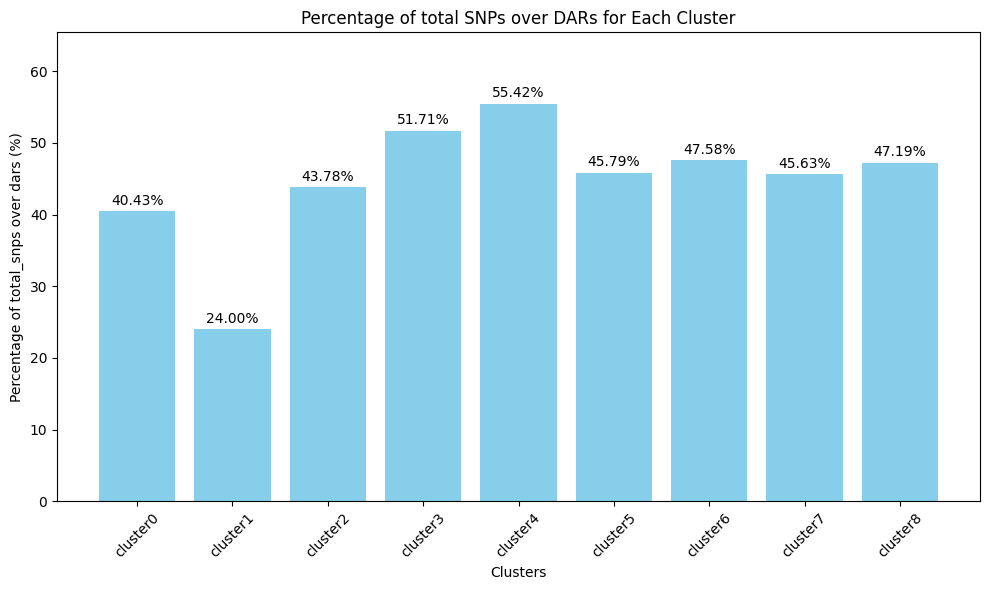

In [23]:
# Calculate the percentage using list comprehension
percentages = [(a / b) * 100 for a, b in zip(grouped_cluster_snps, grouped_cluster)]

print("Percentages: ", percentages)

# Define cluster labels
clusters = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8']

# Plotting the percentages
plt.figure(figsize=(10, 6))
plt.bar(clusters, percentages, color='skyblue')
plt.xlabel('Clusters')
plt.ylabel('Percentage of total_snps over dars (%)')
plt.title('Percentage of total SNPs over DARs for Each Cluster')
plt.xticks(rotation=45)
plt.ylim(0, max(percentages) + 10)  # Adjust y-axis limit for better visibility
plt.tight_layout()

# Adding the percentage values on top of the bars
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()

In [38]:
print(grouped)

status  0.0   1.0
key              
0        15    27
1         2     3
2       802  1820
3       469   997
4        84   177
5       680  1462
6       885  1882
7       604  1108
8       503   947


In [17]:
del snps_peaks_clusters

In [18]:
del snps_peaks_joined_table

## Significance

In [24]:
dff.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val
10,chr5,31809003,7,2.591634,0.0,31809378,31809379,rs16901583,0.09998
15,chr7,55573942,6,0.763615,0.0,55574013,55574014,rs35990173,0.09990
17,chr14,33413212,5,0.666431,0.0,33413356,33413357,rs117427435,0.09996
25,chr19,43765378,6,0.614009,0.0,43765556,43765557,rs76057752,0.09998
37,chr1,29984963,6,1.457652,0.0,29985187,29985188,rs116815646,0.09992


In [25]:
dff.loc[:, '-log_pval'] = -np.log10(dff['p_val'] + 1e-10)

In [26]:
dff.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val,-log_pval
10,chr5,31809003,7,2.591634,0.0,31809378,31809379,rs16901583,0.09998,1.000087
15,chr7,55573942,6,0.763615,0.0,55574013,55574014,rs35990173,0.09990,1.000435
17,chr14,33413212,5,0.666431,0.0,33413356,33413357,rs117427435,0.09996,1.000174
25,chr19,43765378,6,0.614009,0.0,43765556,43765557,rs76057752,0.09998,1.000087
37,chr1,29984963,6,1.457652,0.0,29985187,29985188,rs116815646,0.09992,1.000348


In [27]:
threshold = -np.log10(0.05)
genomewideline= -np.log10(5e-8)
suggestive= -np.log10(1e-5)

results = {
    'Cluster': [],
    'Not_significant': [],
    'Significant': [],
    'Suggestive': [],
    'Genomewideline': []
}

# Iterate through each unique cluster
for i in dff['key'].unique():
    results['Cluster'].append(f'cluster{i}')
    
    # Not significant
    not_significant_count = dff[
        (dff['key'] == i) & 
        (dff['-log_pval'] < threshold)
    ].shape[0]
    results['Not_significant'].append(not_significant_count)
    
    # Significant
    significant_count = dff[
        (dff['key'] == i) & 
        (dff['-log_pval'] >= threshold) & 
        (dff['-log_pval'] < suggestive)
    ].shape[0]
    results['Significant'].append(significant_count)
    
    # Suggestive
    suggestive_count = dff[
        (dff['key'] == i) & 
        (dff['-log_pval'] >= suggestive) & 
        (dff['-log_pval'] < genomewideline)
    ].shape[0]
    results['Suggestive'].append(suggestive_count)
    
    # Genomewideline
    genomewideline_count = dff[
        (dff['key'] == i) & 
        (dff['-log_pval'] >= genomewideline)
    ].shape[0]
    results['Genomewideline'].append(genomewideline_count)

# Convert the results dictionary to a DataFrame
df_temp = pd.DataFrame(results)

# Set the 'Cluster' column as the index
df_temp.set_index('Cluster', inplace=True)

# Display the DataFrame
print(df_temp)

          Not_significant  Significant  Suggestive  Genomewideline
Cluster                                                           
cluster7              757          837          13               7
cluster6             1120         1300          27              18
cluster5              863         1000          21               5
cluster2             1046         1137           7               1
cluster8              639          737           8               1
cluster3              600          720          13              12
cluster0               16           22           0               0
cluster4              109          122           1               3
cluster1                2            4           0               0


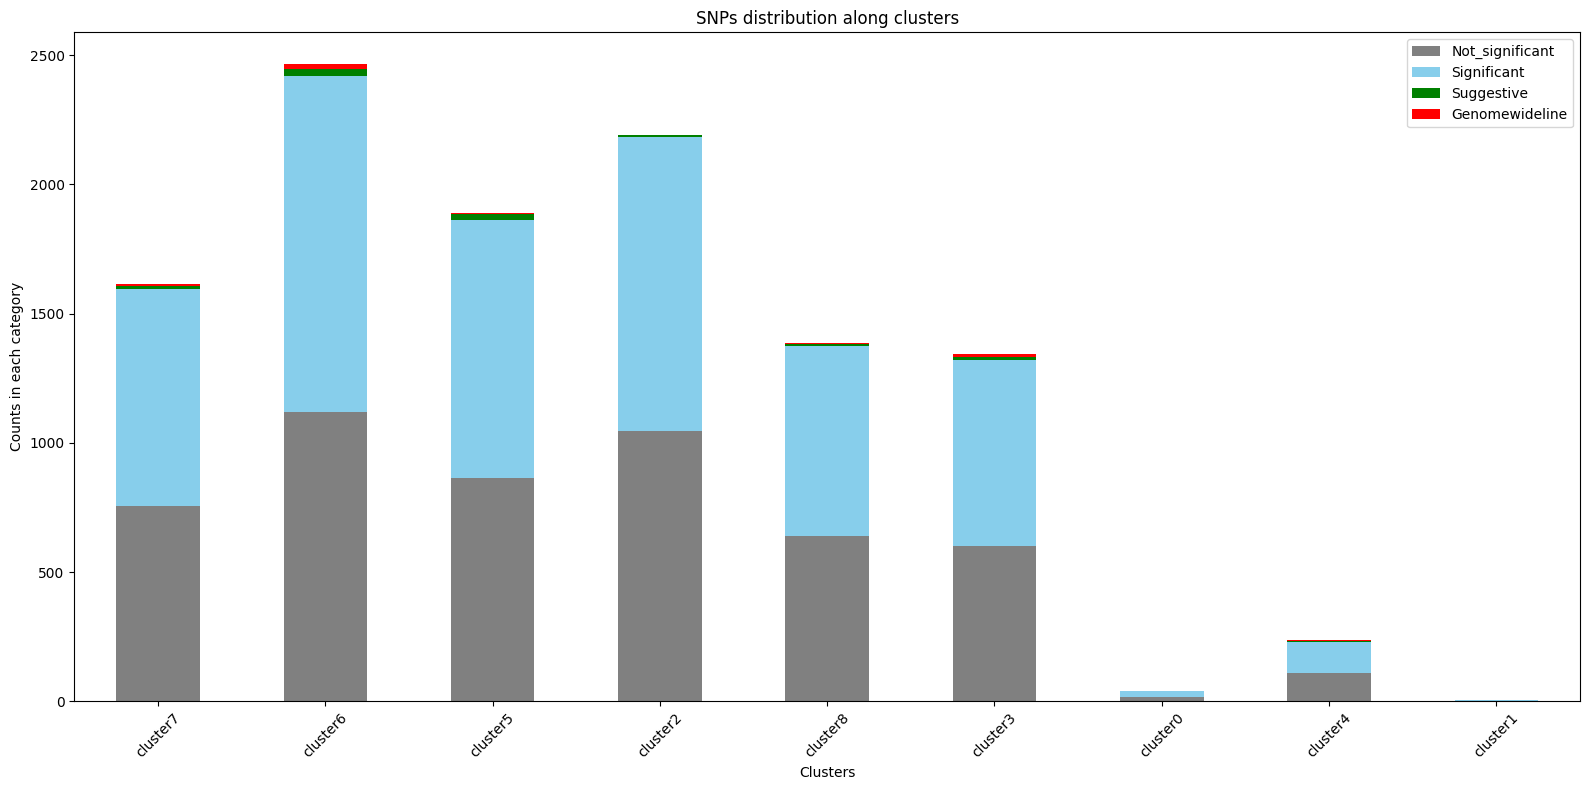

In [28]:
ax = df_temp.plot(kind='bar', stacked=True, color=['gray', 'skyblue', 'green', 'red'], figsize=(16, 8))

# # Adding annotations
# for container in ax.containers:
#     ax.bar_label(container, label_type='center')

# Customize plot
plt.xlabel('Clusters')
plt.ylabel('Counts in each category')
plt.title('SNPs distribution along clusters')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## venn diagram

In [29]:
from matplotlib_venn import venn2, venn3

In [30]:
df.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val
23,chr1,29984963,AD,0.249338,5.063004e-70,29985187,29985188,rs116815646,0.09992
48,chr2,127045632,nonAD,0.226506,3.682617e-58,127045806,127045807,rs142041568,0.09982
103,chr9,26217228,nonAD,0.208859,2.427580e-25,26217404,26217405,rs141576725,0.09970
133,chr22,49971310,AD,0.206962,2.780987e-74,49971650,49971651,rs1054907248,0.09961
149,chr3,15269461,AD,0.211062,3.598278e-129,15269488,15269489,rs773492767,0.09955


In [31]:
ad=df.loc[df['key']=='AD',:]['rsid'].tolist()
nonad=df.loc[df['key']=='nonAD',:]['rsid'].tolist()

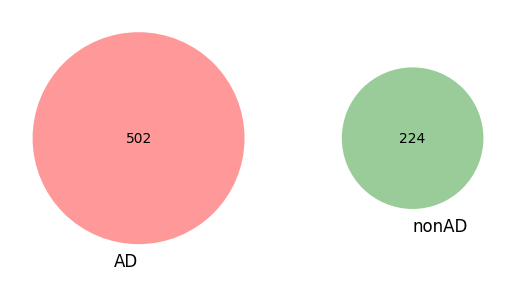

In [32]:
venn2([set(ad), set(nonad)], set_labels = ('AD', 'nonAD'))

In [34]:
def show_venn(cluster_num):
    cluster=dff.loc[dff['key']==cluster_num,:]['rsid'].tolist()
    venn3([set(ad), set(nonad), set(cluster)], set_labels = ('AD', 'nonAD', f'Cluster{cluster_num}'))

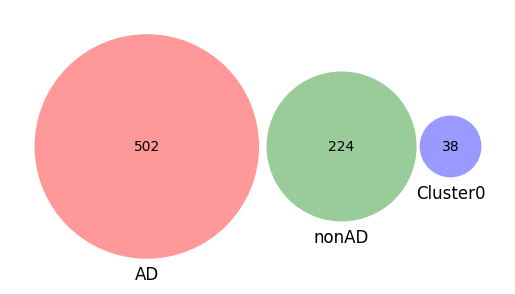

In [35]:
show_venn('0')

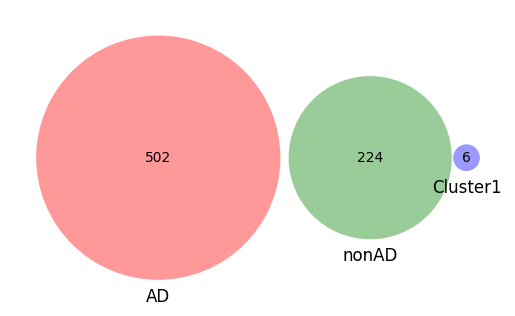

In [36]:
show_venn('1')

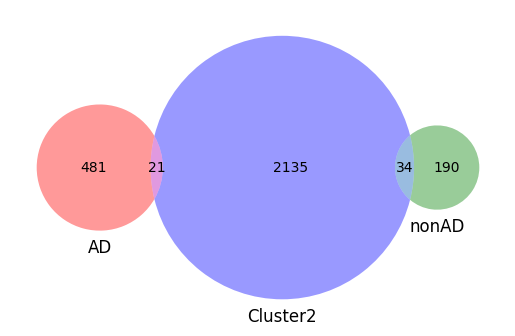

In [37]:
show_venn('2')

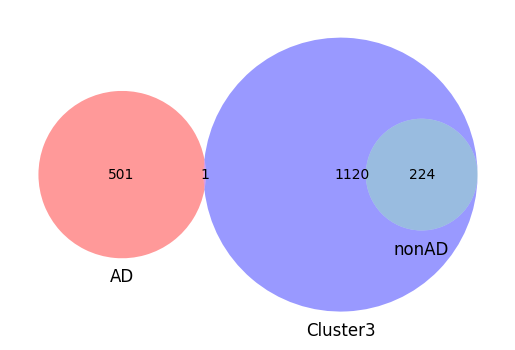

In [38]:
show_venn('3')

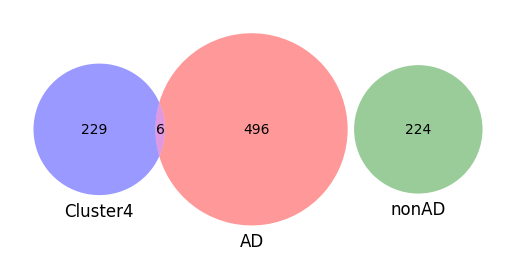

In [39]:
show_venn('4')

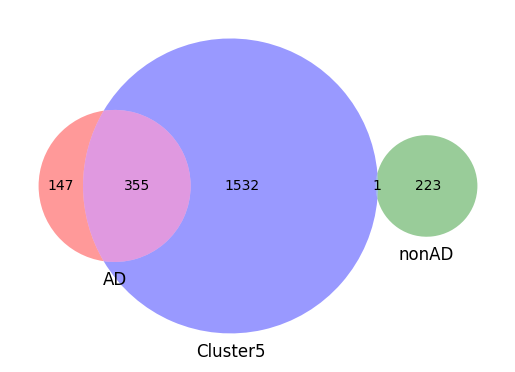

In [40]:
show_venn('5')

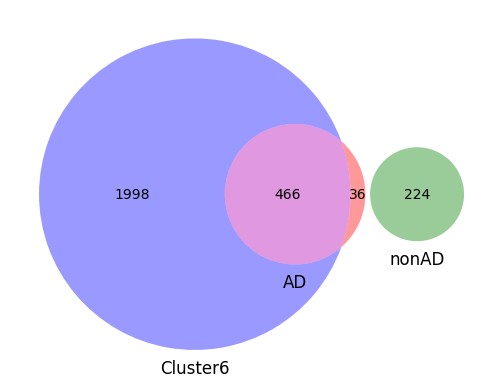

In [41]:
show_venn('6')

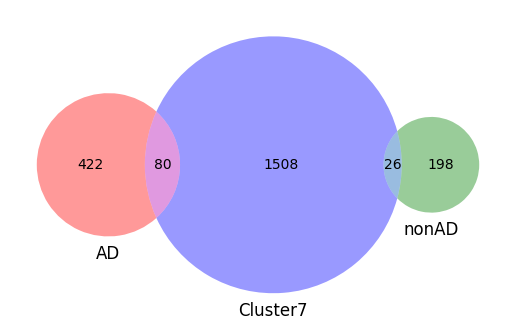

In [42]:
show_venn('7')

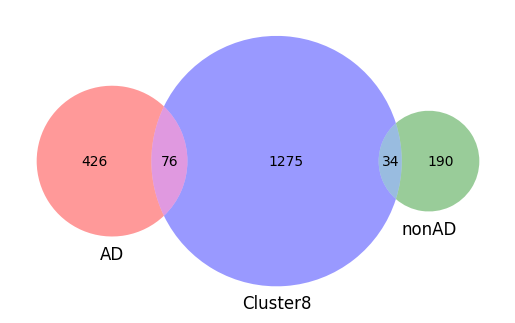

In [43]:
show_venn('8')

## correlation

In [44]:
all=pd.concat([df,dff])

In [45]:
all.key.unique()

array(['AD', 'nonAD', '7', '6', '5', '2', '8', '3', '0', '4', '1'],
      dtype=object)

In [46]:
all.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val,-log_pval
23,chr1,29984963,AD,0.249338,5.063004e-70,29985187,29985188,rs116815646,0.09992,NaN
48,chr2,127045632,nonAD,0.226506,3.682617e-58,127045806,127045807,rs142041568,0.09982,NaN
103,chr9,26217228,nonAD,0.208859,2.427580e-25,26217404,26217405,rs141576725,0.09970,NaN
133,chr22,49971310,AD,0.206962,2.780987e-74,49971650,49971651,rs1054907248,0.09961,NaN
149,chr3,15269461,AD,0.211062,3.598278e-129,15269488,15269489,rs773492767,0.09955,NaN


In [47]:
unique_rsids = all['rsid'].unique()
unique_keys = all['key'].unique()
result_df = pd.DataFrame(0, index=unique_rsids, columns=unique_keys)
for key in unique_keys:
    key_rsids = all[all['key'] == key]['rsid']
    result_df.loc[key_rsids, key] = 1

In [48]:
result_df.shape

(7824, 11)

In [49]:
result_df.head()

,AD,nonAD,7,6,5,2,8,3,0,4,1
rs116815646,1,0,0,1,1,0,0,0,0,0,0
rs142041568,0,1,0,0,0,0,0,1,0,0,0
rs141576725,0,1,0,0,0,1,0,1,0,0,0
rs1054907248,1,0,0,1,0,0,0,0,0,0,0
rs773492767,1,0,1,1,1,0,1,0,0,0,0


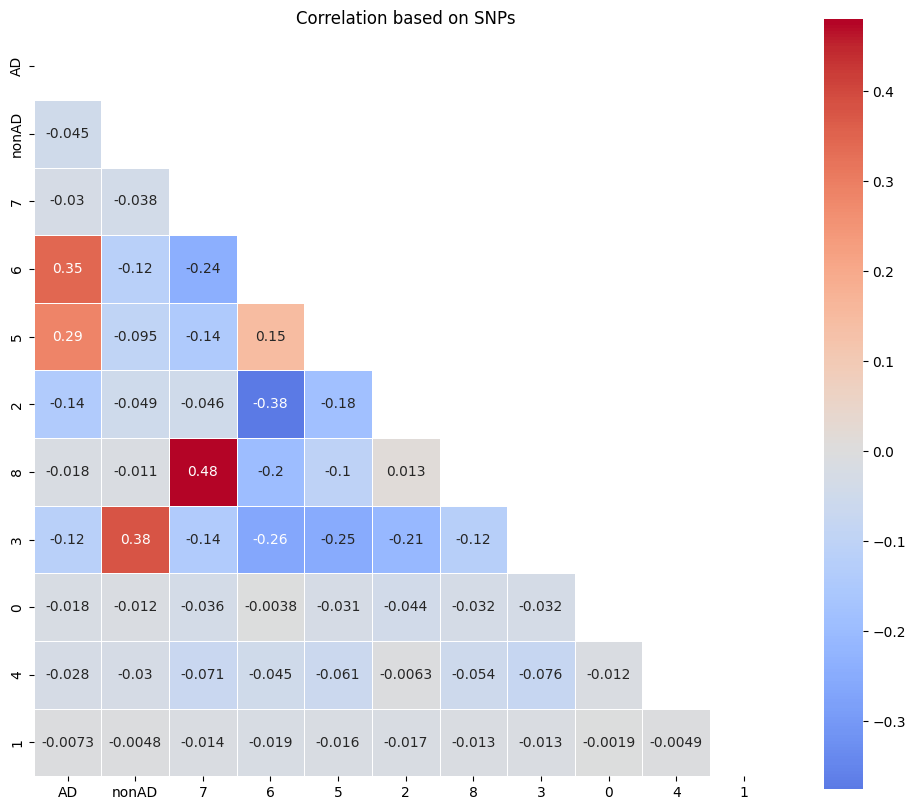

In [50]:
corr=result_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, square=True, linewidths=.5, center=0)
plt.title('Correlation based on SNPs')
# Show the plot
plt.show()

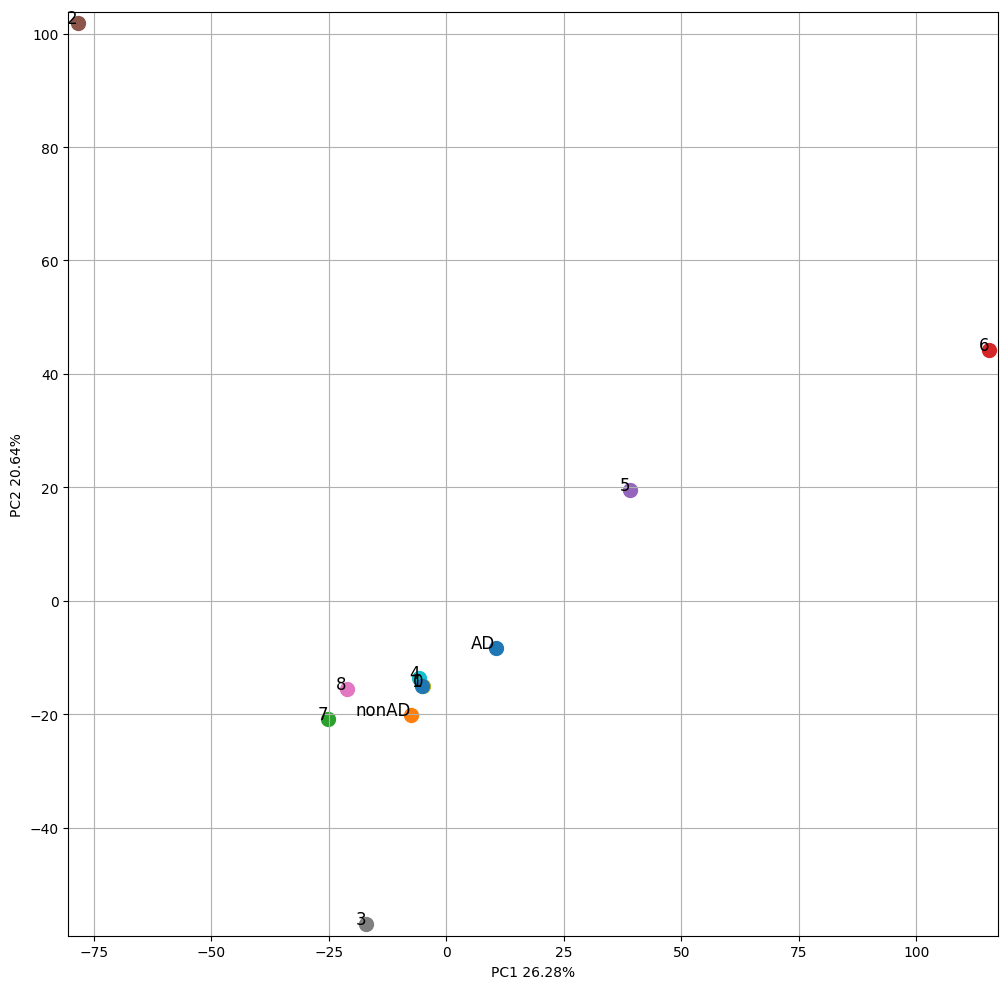

In [51]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(result_df.T)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
principal_df = pd.DataFrame(data=principal_components, index=result_df.columns, columns=['PC1', 'PC2'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot points and add text labels
for name, row in principal_df.iterrows():
    plt.scatter(row.PC1, row.PC2, marker='o', s=100)  # s=100 for larger points
    plt.text(row.PC1, row.PC2, name, fontsize=12, ha='right')

# Set limits
plt.xlim(principal_df.PC1.min() - 2, principal_df.PC1.max() + 2)
plt.ylim(principal_df.PC2.min() - 2, principal_df.PC2.max() + 2)

# Add explained variance ratio to labels
explained_variance_ratio = pca.explained_variance_ratio_
plt.xlabel(f'PC1 {100*explained_variance_ratio[0]:.2f}%')
plt.ylabel(f'PC2 {100*explained_variance_ratio[1]:.2f}%')

# Show the plot
plt.grid()
plt.show()